### Libraries and Modules

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io
from PIL import Image

# Modules
from RICM_VESICLE import RICM, Height_map
from FITTING import Fit_Gaussian

### Determine the Shot and the GUV


In [2]:
# Determine the Shot and the GUV
experiment = '202210215_GUV_Bio5_SOPC5'
shot, guv = 9, 2

### Read the whole RICM image to determine the base line

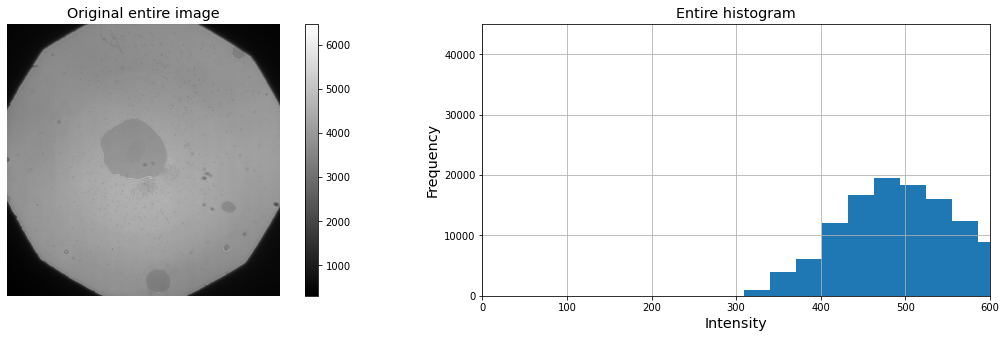

In [3]:
# Read the RICM image
RICM_img = io.imread(f"Data/{experiment}/data/AVG_vesicle_{shot}_MMStack_Default.ome.tif")

# display the image and it's histogram
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.axis('off')
plt.title('Original entire image', fontsize='x-large')
plt.imshow(RICM_img, cmap = "gray")
plt.colorbar()

plt.subplot(122)
plt.title('Entire histogram', fontsize='x-large')
plt.hist(RICM_img.ravel(), bins = 200)
plt.xlabel('Intensity', fontsize='x-large')
plt.ylabel('Frequency', fontsize='x-large')
plt.xlim(0,600)
plt.grid();

### Read the GUV image and subtract the base line

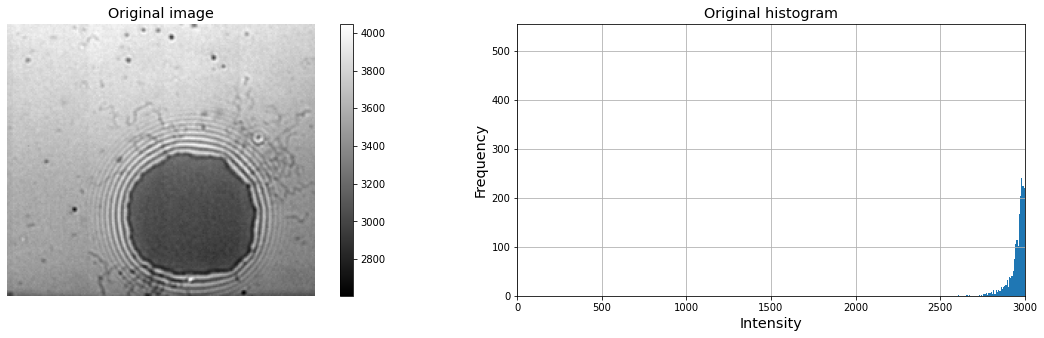

In [4]:
# Read the GUV image
img = io.imread(f"Data/{experiment}/data/AVG_vesicle_{shot}_MMStack_Default.ome-{guv}.tif")

# Subtract the base line
img = img - 310

# display the image and it's histogram
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.axis('off')
plt.title('Original image', fontsize='x-large')
plt.imshow(img, cmap = "gray")
plt.colorbar();

plt.subplot(122)
plt.title('Original histogram', fontsize='x-large')
plt.xlabel('Intensity', fontsize='x-large')
plt.ylabel('Frequency', fontsize='x-large')
plt.hist(img.ravel(), bins = 200)
plt.xlim(0,3000)
plt.grid();

### Define the RICM model

Y0 = 0.01, A = -0.24, h0 = 32.11
Y0 = 0.01, A = -0.24, h0 = 32.11


/home/ahmed/Repositories/Membrane-Topography/RICM_VESICLE.py:268: RuntimeWarning: invalid value encountered in arccos
  return (self.l/(4*np.pi*self.n_outer)) * (np.arccos((Y0-img_normalized)/A) - 2*np.pi*self.p) + h0


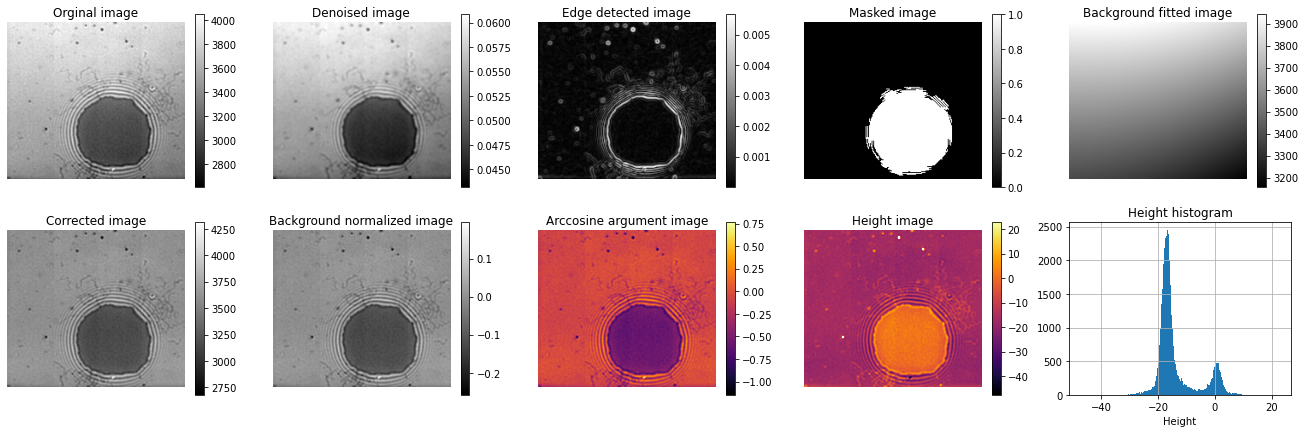

Y0 = 0.01, A = -0.24, h0 = 32.11


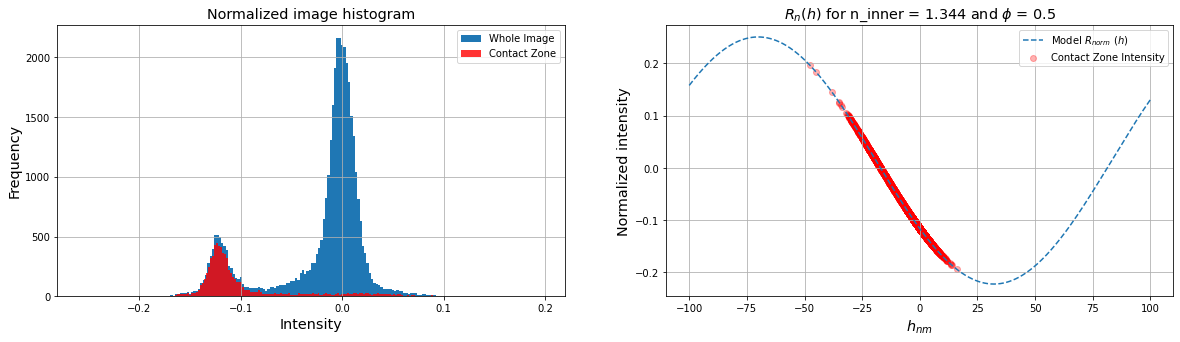

In [5]:
# Define the Height range
h = np.linspace(-100, 100, 600)

# Define the RICM class with certain n_inner
ricm = RICM(img, n_inner=1.344, p=0.5, hole=3)

# Display the way to the RICM height mapping step by step
ricm.show_summary()

# Define the Normalized intensity, heghiet
i_norm = ricm.background_normalization()
height = ricm.height(h)
mask = ricm.mask()

# Get the intensity vs height on the contact zone                    
i_norm_img = []
h_img = []
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if mask[i,j] == 1:     # only the contact zone
            i_norm_img.append(i_norm[i,j])
            h_img.append(height[i,j])
            
# Convert the lists to numpy arrays
i_norm_img = np.array(i_norm_img)
h_img = np.array(h_img)

# Normalized image 
plt.figure(figsize=(20,5))

# The histogram of the normalized image
plt.subplot(121)
plt.hist(ricm.background_normalization().ravel(), bins=200, label='Whole Image')
plt.hist(i_norm_img.ravel(), bins=200, color='r', alpha=0.8, label='Contact Zone')
plt.title('Normalized image histogram', fontsize='x-large')
plt.xlabel('Intensity', fontsize='x-large')
plt.ylabel('Frequency', fontsize='x-large')
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(h, ricm.R5_norm(h), '--', label = 'Model $R_{norm}\ (h)$')
plt.scatter(h_img, i_norm_img, color = 'r', alpha = 0.3, label = 'Contact Zone Intensity')
plt.title(f'$R_n(h)$ for n_inner = {ricm.n_inner} and $\phi$ = {ricm.p}', fontsize='x-large')
plt.xlabel('$h_{nm}$', fontsize='x-large')
plt.ylabel('Normalized intensity', fontsize='x-large')
plt.legend()
plt.grid()

# Show the results
plt.show()

### Fit a gaussian on the adhesion zone

The height of the GUV is 0.66 nm


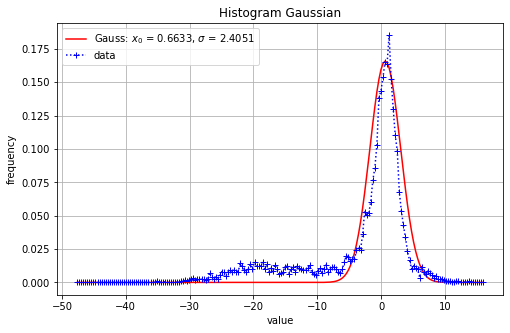

In [6]:
# Fit a gaussian on the adhesion zone histogram
gauss = Fit_Gaussian(h_img, normalized=True)
height, _ = gauss.hist_fitting(show=True)

# Print the height in nano meter
print(f'The height of the GUV is {height:.2f} nm')

### Save the images in tif format

In [7]:
# Create the results directory
os.mkdir(f'Data/{experiment}/results/AVG_vesicle_{shot}_MMStack_Default.ome-{guv}_{height:.2f}nm')

# Save the results
Image.fromarray(img).save(
    f'Data/{experiment}/results/AVG_vesicle_{shot}_MMStack_Default.ome-{guv}_{height:.2f}nm/original.tif')
Image.fromarray(ricm.nl_denoise()).save(
    f'Data/{experiment}/results/AVG_vesicle_{shot}_MMStack_Default.ome-{guv}_{height:.2f}nm/nl_denoise.tif')
Image.fromarray(ricm.edge_detection()).save(
    f'Data/{experiment}/results/AVG_vesicle_{shot}_MMStack_Default.ome-{guv}_{height:.2f}nm/edge_detection.tif')
Image.fromarray(ricm.mask()).save(
    f'Data/{experiment}/results/AVG_vesicle_{shot}_MMStack_Default.ome-{guv}_{height:.2f}nm/mask.tif')
Image.fromarray(ricm.background_fitting()).save(
    f'Data/{experiment}/results/AVG_vesicle_{shot}_MMStack_Default.ome-{guv}_{height:.2f}nm/background_fitting.tif')
Image.fromarray(ricm.correct()).save(
    f'Data/{experiment}/results/AVG_vesicle_{shot}_MMStack_Default.ome-{guv}_{height:.2f}nm/correct.tif')
Image.fromarray(ricm.background_normalization()).save(
    f'Data/{experiment}/results/AVG_vesicle_{shot}_MMStack_Default.ome-{guv}_{height:.2f}nm/background_normalization.tif')
Image.fromarray(ricm.height()).save(
    f'Data/{experiment}/results/AVG_vesicle_{shot}_MMStack_Default.ome-{guv}_{height:.2f}nm/height.tif')

Y0 = 0.01, A = -0.24, h0 = 32.11


/home/ahmed/Repositories/Membrane-Topography/RICM_VESICLE.py:268: RuntimeWarning: invalid value encountered in arccos
  return (self.l/(4*np.pi*self.n_outer)) * (np.arccos((Y0-img_normalized)/A) - 2*np.pi*self.p) + h0
